# Introduction

In this notebook, I build a machine learning model using python which predicts whether a customer will churn (leave the company) or not. Logistic Regression and XGB Classifier has been implemented and compared, also the XGB model is fine-tuned using GridSearchCV. 

### Importing the libraries 

In [1]:
import kagglehub
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

/opt/conda/envs/cp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("yeanzc/telco-customer-churn-ibm-dataset")
file_path = glob.glob(path+'/*')[0]
print("Path to dataset files:", file_path)

Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/yeanzc/telco-customer-churn-ibm-dataset/versions/1/Telco_customer_churn.xlsx


In [4]:
churn_df = pd.read_excel(file_path)

In [5]:
churn_df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


# EDA & Feature Selection

In [6]:
# Shape of the dataset
churn_df.shape

(7043, 33)

In [7]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [8]:
# Check for null
churn_df.isna().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [9]:
## Dupicate rowa present or not
churn_df.duplicated().sum()

0

In [10]:
#### we have total charges values in terms of object and also contains empty string, converting it to a numeric data type 
churn_df['Total Charges'] = pd.to_numeric(churn_df['Total Charges'], errors='coerce')

In [11]:
churn_df.isna().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

**we can replace the null values in Total Charges by "Tenure Months * Monthly Charges", subscription for (Tenure Months = total number of month,Monthly Charges = cost at each month)**

In [12]:
churn_df['Total Charges'] = churn_df['Total Charges'].fillna(churn_df['Tenure Months']*churn_df['Monthly Charges'])

**We do not need the "Churn reason" col to do a predictive analysis it has more than 50% of data null. Also, "Churn Value" and "Churn Label" are the same except for their data type, i.e; (0 or 1) and (Yes or No).**

In [13]:
#Drop Churn Reason and Churn Label cols
churn_df.drop("Churn Reason", inplace = True, axis = 1)
churn_df.drop("Churn Label", inplace = True, axis = 1)

In [14]:
# Lets explore our target variable "Churn Label"
churn_df['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

**We have a significant imbalance in the datset, but before we treat the imbalance lets explore our explantory variables.**

Lets look into the catagorical cols first:

In [15]:
# Create list of catagorical cols
Cat_cols = []

for col in churn_df.columns:
    if churn_df[col].dtype == "object":
        Cat_cols.append(col)

print(f"We have {len(Cat_cols)} catagorical columns:")
Cat_cols

We have 21 catagorical columns:


['CustomerID',
 'Country',
 'State',
 'City',
 'Lat Long',
 'Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method']

**Lets find out the number of binary cols**

In [16]:
# Lets find out the number of binary variables
binary_cols = []

for col in churn_df.columns:
    if churn_df[col].value_counts().shape[0] ==2:
        binary_cols.append(col)

print("We have {} binary columns:".format(len(binary_cols)))
binary_cols

We have 7 binary columns:


['Gender',
 'Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Paperless Billing',
 'Churn Value']

Lets examine distribution of these variables:

<Axes: xlabel='Phone Service', ylabel='count'>

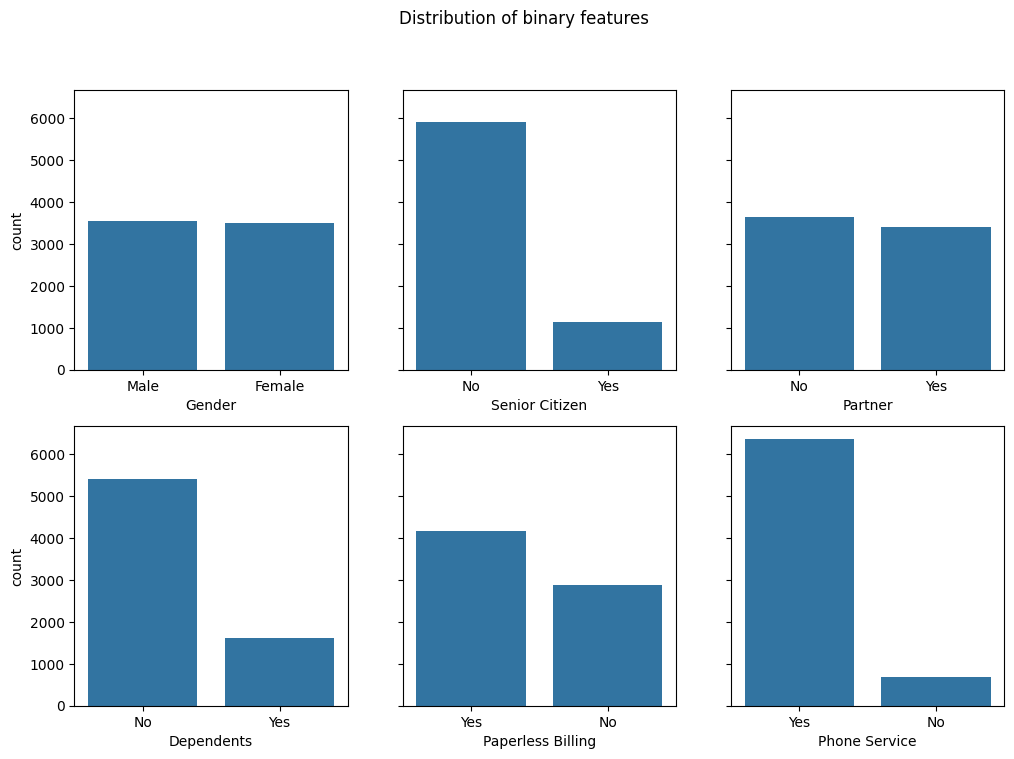

In [17]:
fig, axes = plt.subplots(2,3, figsize = (12,8), sharey = True)
plt.suptitle("Distribution of binary features")
sns.countplot(x = "Gender", data = churn_df, ax=axes[0,0])
sns.countplot(x = "Senior Citizen", data = churn_df, ax=axes[0,1])
sns.countplot(x = "Partner", data = churn_df, ax=axes[0,2])
sns.countplot(x = "Dependents", data = churn_df, ax=axes[1,0])
sns.countplot(x = "Paperless Billing", data = churn_df, ax=axes[1,1])
sns.countplot(x = "Phone Service", data = churn_df, ax=axes[1,2])

#### We can observe high imbalance in:

* Senior Citizen - Most of the customers are below the age of 65 years
* Dependents - Majority do not live with any dependent (kids, parents etc) 
* Phone Service - Most use phone service

#### Lets explore how these variables affect the average churn rate

In [18]:
churn_df[['Gender', 'Churn Value']].groupby(['Gender']).mean()

,Churn Value
Gender,
Female,0.269209
Male,0.261603


In [19]:
churn_df[['Senior Citizen', 'Churn Value']].groupby('Senior Citizen').mean()

,Churn Value
Senior Citizen,
No,0.236062
Yes,0.416813


In [20]:
churn_df[['Partner', 'Churn Value']].groupby('Partner').mean()

,Churn Value
Partner,
No,0.329580
Yes,0.196649


In [21]:
churn_df[['Dependents', 'Churn Value']].groupby('Dependents').mean()

,Churn Value
Dependents,
No,0.325517
Yes,0.065151


In [22]:
churn_df[['Phone Service', 'Churn Value']].groupby('Phone Service').mean()

,Churn Value
Phone Service,
No,0.249267
Yes,0.267096


In [23]:
churn_df[['Paperless Billing', 'Churn Value']].groupby('Paperless Billing').mean()

,Churn Value
Paperless Billing,
No,0.163301
Yes,0.335651


In [24]:
# Get all non-binary catagorical variables
non_binary_cat_cols = [i for i in Cat_cols if i not in binary_cols ]
non_binary_cat_cols

['CustomerID',
 'Country',
 'State',
 'City',
 'Lat Long',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Payment Method']

In [25]:
churn_df['City'].value_counts()

City
Los Angeles       305
San Diego         150
San Jose          112
Sacramento        108
San Francisco     104
                 ... 
Healdsburg          4
Jenner              4
Philo               4
Point Arena         4
Olympic Valley      4
Name: count, Length: 1129, dtype: int64

Country and state columns does not provide any variablity as all the observations are from California, U.S. Also, the observations are distributed across 1,129 cites, so on an average its 6.5 observations per city. 

So we will omit aa the geographical columns in our model.

### Inspecting other catagorical variables

In [26]:
# Impact on churn value
churn_df[['Multiple Lines', 'Churn Value']].groupby('Multiple Lines').mean().sort_values(by = 'Churn Value', ascending=False)

,Churn Value
Multiple Lines,
Yes,0.286099
No,0.250442
No phone service,0.249267


Customers with multipe lines connection have a higher churn rate. 

In [27]:
# Impact on churn value
churn_df[['Internet Service', 'Churn Value']].groupby('Internet Service').mean().sort_values(by= 'Churn Value', ascending = False)

,Churn Value
Internet Service,
Fiber optic,0.418928
DSL,0.189591
No,0.074050


People with Fiber Optic have a much higher churn rate. Lets explore the factor behind it

In [28]:
churn_df[['Monthly Charges', 'Internet Service']].groupby('Internet Service').mean().sort_values(by = 'Monthly Charges')

,Monthly Charges
Internet Service,
No,21.079194
DSL,58.102169
Fiber optic,91.500129


The monthly charges for fiber optic connection is much higher than the other two.

### Lets explore the internet related features

Though these services are offered for free by the company, most people do not use them. Lets see if these feature impact the churn rate

In [29]:
churn_df[['Online Security', 'Churn Value']].groupby('Online Security').mean().sort_values(by='Online Security')

,Churn Value
Online Security,
No,0.417667
No internet service,0.074050
Yes,0.146112


In [30]:
churn_df[['Device Protection', 'Churn Value']].groupby('Device Protection').mean().sort_values(by='Device Protection')

,Churn Value
Device Protection,
No,0.391276
No internet service,0.074050
Yes,0.225021


In [31]:
churn_df[['Online Backup', 'Churn Value']].groupby('Online Backup').mean().sort_values(by='Online Backup')

,Churn Value
Online Backup,
No,0.399288
No internet service,0.074050
Yes,0.215315


In [32]:
churn_df[['Tech Support', 'Churn Value']].groupby('Tech Support').mean().sort_values(by='Tech Support')

,Churn Value
Tech Support,
No,0.416355
No internet service,0.074050
Yes,0.151663


In [33]:
churn_df[['Streaming TV', 'Churn Value']].groupby('Streaming TV').mean().sort_values(by='Streaming TV')

,Churn Value
Streaming TV,
No,0.335231
No internet service,0.074050
Yes,0.300702


In [34]:
churn_df[['Streaming Movies', 'Churn Value']].groupby('Streaming Movies').mean().sort_values(by='Streaming Movies')

,Churn Value
Streaming Movies,
No,0.336804
No internet service,0.074050
Yes,0.299414


So the conclusion is people who don't opt for these internet services have a high churn rate. However, the churn rate difference between customers who use and do not use Streaming TV and Streaming Movies is quite low.

### Exploring Contract and Payment Method

Text(0.5, 1.0, 'Customers by Contract Type')

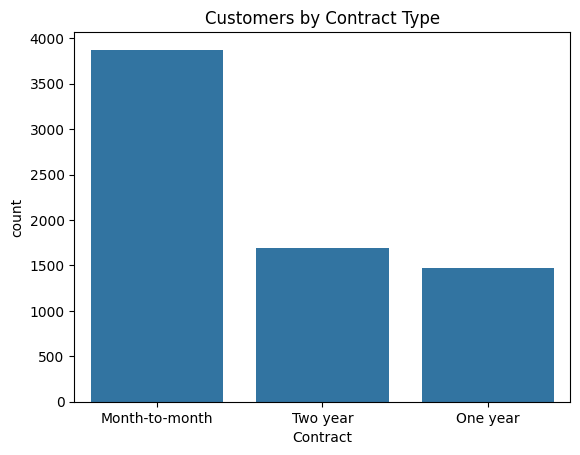

In [35]:
sns.countplot(x = 'Contract', data = churn_df)
plt.title('Customers by Contract Type')

In [37]:
churn_df[['Contract', 'Churn Value']].groupby('Contract').mean()

,Churn Value
Contract,
Month-to-month,0.427097
One year,0.112695
Two year,0.028319


No surprises here - Customers with shorter contract tend to churn more

Text(0.5, 1.0, 'Customers by Contract Type')

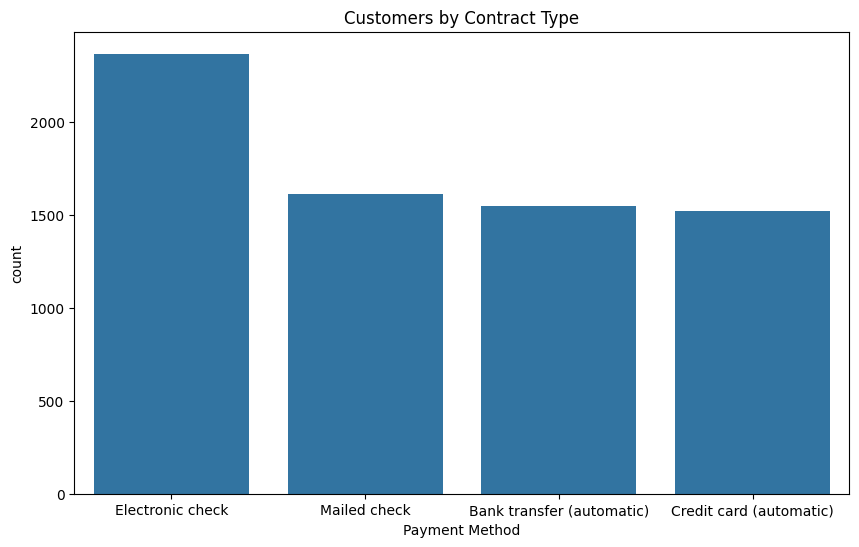

In [36]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'Payment Method', data = churn_df, order = churn_df['Payment Method'].value_counts().index)
plt.title('Customers by Contract Type')

In [37]:
churn_df[['Payment Method', 'Churn Value']].groupby('Payment Method').mean().sort_values(by = 'Churn Value',ascending = False)

,Churn Value
Payment Method,
Electronic check,0.452854
Mailed check,0.191067
Bank transfer (automatic),0.167098
Credit card (automatic),0.152431


Here is something interesting, customers who pay electronic check are more likely to churn and also this payment method is most common among the costumers.

### Exploring Continuous Feature

In [38]:
num_cols = []
for col in churn_df.columns:
    if churn_df[col].dtype.kind in 'iufc':
        num_cols.append(col)
num_cols

['Count',
 'Zip Code',
 'Latitude',
 'Longitude',
 'Tenure Months',
 'Monthly Charges',
 'Total Charges',
 'Churn Value',
 'Churn Score',
 'CLTV']

### Here we have three numerical variables to deal with:

* Tenure Month - How long the customer has been with the company
* Monthly Charges 
* CLTV - Customer Lifetime Value

Note: We are ommiting Total Charges becasue its Tenure times Monthly Charges


In [39]:
churn_df[churn_df['Churn Value'] == 1]['Tenure Months'].describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: Tenure Months, dtype: float64

**Customers with lower tenure tend to churn more and vice-versa.**

**As the monthly charges go up customers tend to churn more.**

In [40]:
churn_df[['Monthly Charges', 'Churn Value', 'Tenure Months']].groupby('Churn Value').mean()

,Monthly Charges,Tenure Months
Churn Value,,
0,61.265124,37.569965
1,74.441332,17.979133


Average monthly charges for churned customers is about 13 dollars higher and churned customers tend to leave the company about 20 months earlier than the not churned ones.

In [41]:
churn_df[['CLTV', 'Churn Value']].groupby('Churn Value').mean()

,CLTV
Churn Value,
0,4490.921337
1,4149.414660


In [42]:
churn_df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score',
       'CLTV'],
      dtype='object')

From the EDA, I have further decided to drop finally I would drop:
1. First 9 cols
2. Gender
3. Total Charges

# Data Pre-processing 

In [43]:
# Filter features
filtered_df = churn_df.iloc[:, 9:]
filtered_df.drop(['Gender','Total Charges'], inplace = True, axis=1)

In [44]:
# Extract catagorical features from selected features 
cat_features = [i for i in filtered_df.columns if filtered_df[i].dtype == 'object']
cat_features

['Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method']

### One-hot encoding the catagorical features

In [45]:
# Encode cat_features
encoded_df = pd.get_dummies(filtered_df, columns = cat_features, drop_first = True)

### Scaling the continous features


In [46]:
from sklearn.preprocessing import MinMaxScaler

In [47]:
# MinMax scaling of continous features 
scaler = MinMaxScaler()
temp_1 = scaler.fit_transform(filtered_df[["Tenure Months"]])
temp_2 = scaler.fit_transform(filtered_df[["Monthly Charges"]])
temp_3 = scaler.fit_transform(filtered_df[['CLTV']])
temp_4 = scaler.fit_transform(filtered_df[['Churn Score']])

In [48]:
# Replacing the original cols with scaled ones 
encoded_df['Tenure Months'] = temp_1
encoded_df['Monthly Charges'] = temp_2
encoded_df['CLTV'] = temp_3
encoded_df['Churn Score'] = temp_4

In [49]:
encoded_df.head()

,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,0.027778,0.354229,1,0.852632,0.274850,False,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
1,0.027778,0.521891,1,0.652632,0.155215,False,False,True,True,False,...,False,False,False,False,False,False,True,False,True,False
2,0.111111,0.809950,1,0.852632,0.749166,False,False,True,True,False,...,False,True,False,True,False,False,True,False,True,False
3,0.388889,0.861194,1,0.831579,0.667111,False,True,True,True,False,...,False,True,False,True,False,False,True,False,True,False
4,0.680556,0.850249,1,0.884211,0.742050,False,False,True,True,False,...,False,True,False,True,False,False,True,False,False,False


**Correlation and Covarinec matrix**

In [50]:
encoded_df.cov()

,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
Tenure Months,0.116352,0.025317,-0.053052,-0.017389,0.035572,0.002083,0.064725,0.018889,0.000852,-0.000852,...,-0.005490,0.046422,-0.005490,0.047558,0.028104,0.081450,0.001031,0.032715,-0.033568,-0.033514
Monthly Charges,0.025317,0.089642,0.025563,0.009074,0.007774,0.024299,0.014491,-0.018199,0.021907,-0.021907,...,-0.094189,0.091703,-0.094189,0.091543,0.000597,-0.009559,0.051817,0.003765,0.038410,-0.047479
Churn Value,-0.053052,0.025563,0.194976,0.066522,-0.014807,0.024559,-0.033199,-0.046259,0.001560,-0.001560,...,-0.041459,0.013582,-0.041459,0.013208,-0.031936,-0.057058,0.041628,-0.024410,0.062965,-0.017009
Churn Score,-0.017389,0.009074,0.066522,0.051339,-0.004756,0.008534,-0.012570,-0.016709,0.001617,-0.001617,...,-0.013587,0.004505,-0.013587,0.005328,-0.010757,-0.019423,0.014402,-0.007999,0.020825,-0.006007
CLTV,0.035572,0.007774,-0.014807,-0.004756,0.069209,-0.000307,0.018125,0.006456,0.001791,-0.001791,...,-0.001249,0.013424,-0.001249,0.014486,0.006031,0.026223,0.001487,0.008554,-0.008784,-0.010276
Senior Citizen_Yes,0.002083,0.024299,0.024559,0.008534,-0.000307,0.135875,0.003036,-0.027096,0.000935,-0.000935,...,-0.027753,0.018896,-0.027753,0.021587,-0.006936,-0.018438,0.028356,-0.003662,0.029895,-0.023769
Partner_Yes,0.064725,0.014491,-0.033199,-0.012570,0.018125,0.003036,0.249748,0.076556,0.002617,-0.002617,...,0.000127,0.030308,0.000127,0.028593,0.016827,0.053005,-0.003654,0.016874,-0.019792,-0.019973
Dependents_Yes,0.018889,-0.018199,-0.046259,-0.016709,0.006456,-0.027096,0.076556,0.177669,0.000078,-0.000078,...,0.029889,-0.011835,0.029889,-0.015069,0.002517,0.034286,-0.024644,0.007158,-0.028165,0.012583
Phone Service_Yes,0.000852,0.021907,0.001560,0.001617,0.001791,0.000935,0.002617,0.000078,0.087469,-0.087469,...,0.020984,-0.003248,0.020984,-0.004750,-0.000336,0.000445,0.002399,-0.000940,0.000428,-0.000412
Multiple Lines_No phone service,-0.000852,-0.021907,-0.001560,-0.001617,-0.001791,-0.000935,-0.002617,-0.000078,-0.087469,0.087469,...,-0.020984,0.003248,-0.020984,0.004750,0.000336,-0.000445,-0.002399,0.000940,-0.000428,0.000412


In [51]:
encoded_df.corr()

,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
Tenure Months,1.000000,0.247900,-0.352229,-0.224987,0.396406,0.016567,0.379697,0.131376,0.008448,-0.008448,...,-0.039062,0.279756,-0.039062,0.286111,0.202570,0.558533,0.006152,0.233006,-0.208363,-0.233852
Monthly Charges,0.247900,1.000000,0.193356,0.133754,0.098693,0.220173,0.096848,-0.144206,0.247398,-0.247398,...,-0.763557,0.629603,-0.763557,0.627429,0.004904,-0.074681,0.352150,0.030550,0.271625,-0.377437
Churn Value,-0.352229,0.193356,1.000000,0.664897,-0.127463,0.150889,-0.150448,-0.248542,0.011942,-0.011942,...,-0.227890,0.063228,-0.227890,0.061382,-0.177820,-0.302253,0.191825,-0.134302,0.301919,-0.091683
Churn Score,-0.224987,0.133754,0.664897,1.000000,-0.079782,0.102181,-0.111013,-0.174950,0.024136,-0.024136,...,-0.145542,0.040869,-0.145542,0.048252,-0.116724,-0.200508,0.129334,-0.085772,0.194603,-0.063099
CLTV,0.396406,0.098693,-0.127463,-0.079782,1.000000,-0.003167,0.137859,0.058222,0.023015,-0.023015,...,-0.011521,0.104889,-0.011521,0.113000,0.056364,0.233151,0.011501,0.078995,-0.070699,-0.092967
Senior Citizen_Yes,0.016567,0.220173,0.150889,0.102181,-0.003167,1.000000,0.016479,-0.174396,0.008576,-0.008576,...,-0.182742,0.105378,-0.182742,0.120176,-0.046262,-0.117000,0.156530,-0.024135,0.171718,-0.153477
Partner_Yes,0.379697,0.096848,-0.150448,-0.111013,0.137859,0.016479,1.000000,0.363430,0.017706,-0.017706,...,0.000615,0.124666,0.000615,0.117412,0.082783,0.248091,-0.014877,0.082029,-0.083852,-0.095125
Dependents_Yes,0.131376,-0.144206,-0.248542,-0.174950,0.058222,-0.174396,0.363430,1.000000,0.000625,-0.000625,...,0.172110,-0.057717,0.172110,-0.073364,0.014680,0.190262,-0.118963,0.041254,-0.141476,0.071056
Phone Service_Yes,0.008448,0.247398,0.011942,0.024136,0.023015,0.008576,0.017706,0.000625,1.000000,-1.000000,...,0.172209,-0.022574,0.172209,-0.032959,-0.002791,0.003519,0.016505,-0.007721,0.003062,-0.003319
Multiple Lines_No phone service,-0.008448,-0.247398,-0.011942,-0.024136,-0.023015,-0.008576,-0.017706,-0.000625,-1.000000,1.000000,...,-0.172209,0.022574,-0.172209,0.032959,0.002791,-0.003519,-0.016505,0.007721,-0.003062,0.003319


In [52]:
sorted_corr_df = encoded_df.corr().loc['Churn Value'].sort_values(key = lambda x : abs(x),ascending = False)

In [53]:
feature_top7 = sorted_corr_df.index[0:7]

In [54]:
feature_top7

Index(['Churn Value', 'Churn Score', 'Tenure Months',
       'Internet Service_Fiber optic', 'Contract_Two year',
       'Payment Method_Electronic check', 'Dependents_Yes'],
      dtype='object')

In [55]:
top_feature_df = encoded_df[feature_top7]

In [56]:
top_feature_df.head()

,Churn Value,Churn Score,Tenure Months,Internet Service_Fiber optic,Contract_Two year,Payment Method_Electronic check,Dependents_Yes
0,1,0.852632,0.027778,False,False,False,False
1,1,0.652632,0.027778,True,False,True,True
2,1,0.852632,0.111111,True,False,True,True
3,1,0.831579,0.388889,True,False,True,True
4,1,0.884211,0.680556,True,False,False,True


## Treating the imbalance using upsampling technique

Text(0.5, 1.0, 'Distribution of Target Before Upsampling')

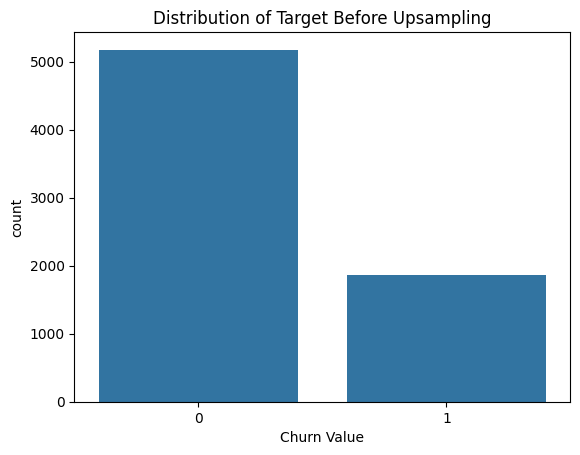

In [57]:
sns.countplot(x = "Churn Value", data = top_feature_df)
plt.title('Distribution of Target Before Upsampling')

In [58]:
churned = top_feature_df[top_feature_df['Churn Value']==1]
not_churned = top_feature_df[top_feature_df['Churn Value'] == 0]

In [59]:
churned_upsampled = resample(churned, 
                             replace = True, 
                             n_samples = len(not_churned),
                             random_state = 1)

Text(0.5, 1.0, 'Distribution of Target After Upsampling')

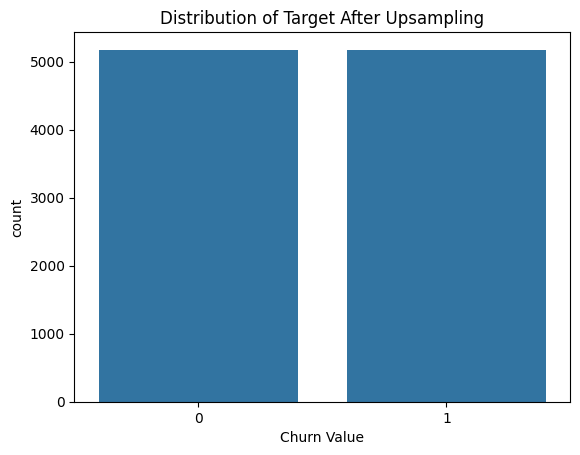

In [60]:
# Combining the upsampled data
final_df = pd.concat([churned_upsampled, not_churned])
sns.countplot(x = "Churn Value", data = final_df)
plt.title("Distribution of Target After Upsampling")

In [61]:
final_df.head()

,Churn Value,Churn Score,Tenure Months,Internet Service_Fiber optic,Contract_Two year,Payment Method_Electronic check,Dependents_Yes
1061,1,0.694737,0.055556,True,False,False,False
235,1,0.778947,0.180556,True,False,True,False
1096,1,0.705263,0.027778,False,False,True,False
1791,1,0.915789,0.152778,False,False,False,False
905,1,0.852632,0.097222,True,False,False,False


# Model Building and Model Selection
1. Logistic Regression
2. XGB Classifier 
3. Parameter tuning using GridSearchCV

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
# Explaintory vars
X = final_df.drop('Churn Value', axis = 1)

# Target var
Y = final_df['Churn Value']

In [64]:
# Separating the dataset into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

## 1. Using LogisticRegression Model

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [66]:
Logi_model = LogisticRegression(max_iter = 500)

In [67]:
Logi_model.fit(X_train, Y_train)

LogisticRegression(max_iter=500)

In [68]:
# Accuracy score on training data
logi_train_pred = Logi_model.predict(X_train)
logi_acc_train = accuracy_score(logi_train_pred, Y_train)
print("Accuracy score on trianing data:",logi_acc_train)

# Accurcy on test data
logi_test_pred = Logi_model.predict(X_test)
logi_acc_test = accuracy_score(logi_test_pred, Y_test)
print("Accuracy score on test data:",logi_acc_test)

Accuracy score on trianing data: 0.9093984054119353
Accuracy score on test data: 0.8995169082125604


That's a very good accuracy score. Also, accuracy score on training and test data are very close, so we can say that our model does not suffer from over-fitting.

Let's look into precision and recall scores:

In [88]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import metrics

In [89]:
logi_recall = recall_score(Y_test,logi_test_pred)
logi_precision = precision_score(Y_test, logi_test_pred)
print("LogisticRegression model's metrics:\n")
print("Accuracy on Training Data:", round(logi_acc_train, 2))
print("Accuracy on Test Data:", round(logi_acc_test,2))
print("Recall Score:", round(logi_recall,2))
print("Precision Score:", round(logi_precision,2))

LogisticRegression model's metrics:

Accuracy on Training Data: 0.91
Accuracy on Test Data: 0.9
Recall Score: 0.91
Precision Score: 0.89


### The logistic model seems very good. Lets build a confusion matrix:

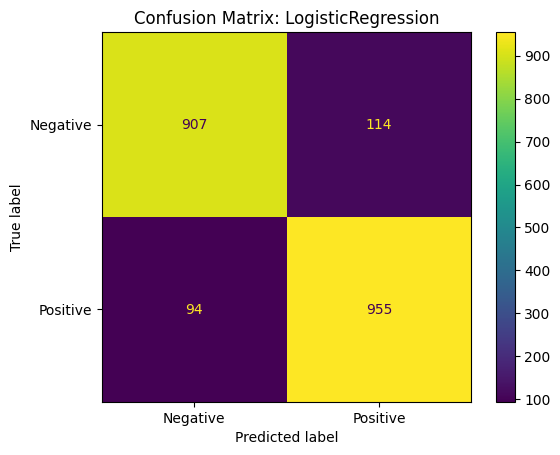

In [90]:
confusion_matrix = metrics.confusion_matrix(Y_test, logi_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Positive'])
cm_display.plot()
plt.title('Confusion Matrix: LogisticRegression')
plt.show()

Lets see if XGBClassifier can deliver a better result:

## 2. Using XGBClasssifer

In [91]:
from xgboost import XGBClassifier

In [92]:
xgb_model = XGBClassifier()

In [93]:
xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
# Accuracy score on training data
xgb_train_pred = xgb_model.predict(X_train)
xgb_acc_train = accuracy_score(xgb_train_pred, Y_train)
# Accuracy score on test data
xgb_test_pred = xgb_model.predict(X_test)
xgb_acc_test = accuracy_score(xgb_test_pred, Y_test)

In [95]:
xgb_recall = recall_score(Y_test,xgb_test_pred)
xgb_precision = precision_score(Y_test, xgb_test_pred)
print("XGBClassification model's metrics:\n")
print("Accuracy on Training Data:", round(xgb_acc_train, 2))
print("Accuracy on Test Data:", round(xgb_acc_test,2))
print("Recall Score:", round(xgb_recall,2))
print("Precision Score:", round(xgb_precision,2))

XGBClassification model's metrics:

Accuracy on Training Data: 0.97
Accuracy on Test Data: 0.95
Recall Score: 0.98
Precision Score: 0.93


### I suspect slight over-fitting here.
Lets try k-fold and parameter tuning

# Parameter tuning 

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
parameters = {'n_estimators':[150,200,250,300], 
              'max_depth':[5,10,15,20,25], 
              'learning_rate': [0.1,0.2,0.3,0.4]}
gscv = GridSearchCV(estimator = xgb_model, param_grid = parameters, cv = 5, n_jobs = -1)

In [98]:
gscv.fit(X,Y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3, 0.4],
                         'max_depth': [5, 10, 15, 20, 25],
                         'n_estimators': [150, 200, 250, 300]})

In [99]:
gscv.best_params_

{'learning_rate': 0.4, 'max_depth': 25, 'n_estimators': 250}

In [100]:
gscv.best_score_

0.956223291608586

### Model with best parameters

In [101]:
best_xgb_model = XGBClassifier(max_depth = 25, n_estimators = 250, learning_rate = 0.4)

In [102]:
best_xgb_model.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=25, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [103]:
# Accuracy score on training data
train_pred = best_xgb_model.predict(X_train)
acc_train = accuracy_score(train_pred, Y_train)

# Accuracy score on test data
test_pred = best_xgb_model.predict(X_test)
acc_test = accuracy_score(test_pred, Y_test)

In [104]:
xgb2_recall = recall_score(Y_test,test_pred)
xgb2_precision = precision_score(Y_test, test_pred)
print("Tuned XGBClassification model's metrics:\n")
print("Accuracy on Training Data:", round(acc_train, 2))
print("Accuracy on Test Data:", round(acc_test,2))
print("Recall Score:", round(xgb2_recall,2))
print("Precision Score:", round(xgb2_precision,2))

Tuned XGBClassification model's metrics:

Accuracy on Training Data: 0.99
Accuracy on Test Data: 0.95
Recall Score: 0.97
Precision Score: 0.93


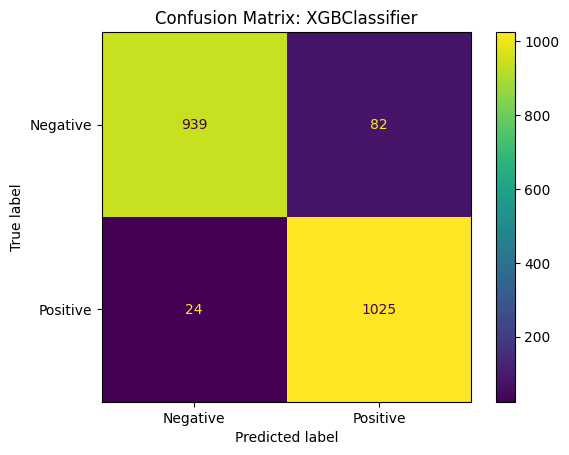

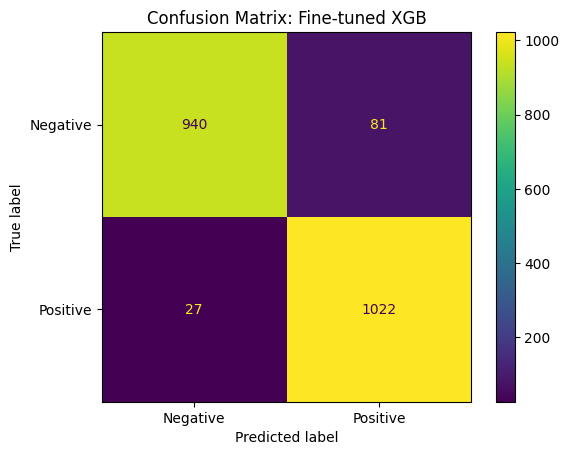

In [105]:
# CM for initial XGB model
confusion_matrix= metrics.confusion_matrix(Y_test, xgb_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Positive'])
cm_display.plot()
plt.title('Confusion Matrix: XGBClassifier')
plt.show()

# CM for fine-tuned XGB model
confusion_matrix= metrics.confusion_matrix(Y_test, test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Positive'])
cm_display.plot()
plt.title('Confusion Matrix: Fine-tuned XGB')
plt.show()

# Conclusion:
Well, that not much of an improvement from the initial XGB model. We have a 1% tradeoff between the recall score, The model tradeoffs 1% ability to aviod false negatives (1% lower recall score).


In this case the XGBClassifier works better than the logistic regression model. 

#### Deciding among the two XGB models:

As per our use-case we don't want the costumers to churn (leave), so when the model predicts that a specific consumer will churn, the company proposes better offers. So here we are more concerned that the we identify the customer who is about to churn **(true positives)**. So I recommend the ***first XGB model***. 
